# <center> UK and US elections code

We import the requested modules and set up some parameters for the plots appearance.

In [1]:
# imports
import re
import sys
import pickle
import numpy as np
import pandas as pd
from time import time
from scipy.linalg import expm
from util import section5_simu
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import text as Text
from matplotlib.lines import Line2D
from matplotlib import rc

# for plots appearance
gov_color = {"Con":"blue", "Lab":"red", "Nat":"orange", "Coa":"green", "?":"black"}
party_color = {"con":"blue", "lab":"red", "rep":"red", "dem":"blue"}
party_color2 = {"con":"darkblue", "lab":"maroon", "dem":"darkblue", "rep":"maroon"}
ls = {"con":":", "lab":"--", "dem":":", "rep":"--"}
mark = {"con":"d", "lab":"o", "dem":"o", "rep":"d"}

# latex rendering
rc('font',**{'family':'sans-serif','sans-serif':['Palatino']})
rc('text', usetex=True)

First we create a useful function to compute a transition rate matrix Q using our voter model based on the values of n,s0,s1.

In [2]:
def Q_matrix(n,s0,s1):
    q = np.zeros((n-s0-s1+1, n-s0-s1+1))
    for k in range(s1,n-s0+1):
        q[k-s1,k-s1-1] = (k-s1)*(n-k)/(n-1)
        if k < n-s0:
            q[k-s1,k-s1+1] = k*(n-k-s0)/(n-1)
        q[k-s1,k-s1] = - (k-s1)*(n-k)/(n-1) - k*(n-k-s0)/(n-1)
    return q

Parameters. Choose the region (UK or US).

In [3]:
n = 100 # nb users
region = "uk" # uk or us

Get parties names.

In [4]:
if region == "uk":
    parties= ("con", "lab")
    party_name = {"con":"Conservative", "lab":"Labour"}
if region == "us":
    parties = ("rep", "dem") 
    party_name = {"rep":"Republicans", "dem":"Democrats"} 

Load dataset and preprocess.

In [5]:
############ UNITED KINGDOM ############
if region == "uk":
    # nb seats for each party
    X = dict()
    for p in parties:
        df = pd.read_csv("data/elections/uk_results.csv")
        x  = np.array(df[p])
        X[p] = np.around(x).astype(int)

    # time
    year = np.array(df["year"])
    year = np.append(year, 2024) # add next election
    T = (year-year[0]).astype(float)
    T[15:] += 0.5

    # nb datapoints
    length = df.shape[0]

############ UNITED STATES ############
if region=="us":
    year = np.array([],dtype=int)
    X = {p: np.array([],dtype=int) for p in parties}
    for line in open("data/elections/1912to1972_raw.txt"):
        if "United States Presidential Election" in line:
            year = np.append(year, int(line[:4]))
            done = {p:False for p in parties}
        if "Republican" in line:
            p = "rep"
        elif "Democratic" in line:
            p = "dem"
        else:
            continue
        x = re.search(r"\d*\.*\d*\%", line)
        x = round(float(x.group()[:-1]))
        if not done[p]:
            X[p] = np.append(X[p],x)
            done[p] = True
        else:
            X[p][-1] += x

    # create timeline, get length
    year = np.append(year,2020)
    T = (year-year[0]).astype(float)
    length = T.size-1

Each election year, we estimate (s0,s1) for Con and Lab based on all the previous results.

In [7]:
estimate = {p:list() for p in parties}
start = time()

for j in range(2, length+1): # new estimates for each datapoint
    
    for p in parties: # for each party
        
        xbar_tmp = X[p][:j].mean()
        s1_max = X[p][:j].min()
        current_max, best_estim = None, None
        count = 0

        for s1 in range(1, s1_max+1): # check all possible values of s1
            s0_max = n-X[p][:j].max()
            #s0 = int(min(s0_max, round((n/xbar[p]-1)*s1)))
            for s0 in range(1, s0_max+1): # check all possible values of s0

                # print status
                count += 1
                sys.stdout.flush()
                sys.stdout.write("Datapoint {}/{} ...... {} ...... (s0,s1) test {}/{} ...... elapsed time {} ...............\r"
                                 .format(j, length, p, count, s1_max*s0_max, time()-start))

                # compute Q
                Q = Q_matrix(n,s0,s1)

                # compute log likelihood
                log_likelihood = 0
                for i in range(1, j):
                    t = T[i] - T[i-1]
                    x, y = X[p][i-1], X[p][i]
                    log_likelihood += np.log(expm(t*Q)[x-s1, y-s1])

                # update max if better
                if current_max == None:
                    current_max, best_estim = log_likelihood, (s0,s1)
                elif log_likelihood > current_max:
                    current_max, best_estim = log_likelihood, (s0,s1)

        # append best estim to S0 and S1 dicts
        estimate[p].append(best_estim)

Show results.

In [8]:
print("Year | {} | {}".format(parties[0], parties[1]))
for i in range(length-1):
    print(year[2:][i], estimate[parties[0]][i], estimate[parties[1]][i])

Year | con | lab
1924 (62, 38) (65, 30)
1929 (20, 21) (61, 30)
1931 (28, 20) (55, 30)
1935 (1, 5) (53, 27)
1945 (9, 10) (48, 26)
1950 (11, 10) (26, 17)
1951 (13, 12) (23, 16)
1955 (13, 12) (23, 16)
1959 (15, 14) (22, 16)
1964 (16, 15) (25, 18)
1966 (18, 16) (25, 18)
1970 (18, 16) (24, 18)
1974 (19, 17) (26, 19)
1974 (19, 16) (26, 19)
1979 (19, 16) (26, 19)
1983 (20, 17) (28, 20)
1987 (20, 17) (22, 15)
1992 (22, 18) (21, 14)
1997 (22, 18) (23, 15)
2001 (19, 15) (24, 16)
2005 (18, 14) (24, 16)
2010 (17, 13) (24, 16)
2015 (18, 13) (22, 14)
2017 (18, 13) (22, 14)
2019 (19, 14) (22, 14)
2024 (19, 14) (24, 15)


Now we compute the predicted distributions, each time based on the most recent estimate of s0,s1.

In [9]:
jump_distrib = {p:list() for p in parties}
maximum = 0
Mean, Std = {p:list() for p in parties}, {p:list() for p in parties}
Max = {p:list() for p in parties}

for p in parties:
    
    jump_distrib[p] = list()
    
    for i in range(2,length+1):
        
        # compute Q but only if it's the first time or s0,s1 are different than last time
        s0,s1 = estimate[p][i-2]
        Q = Q_matrix(n,s0,s1)
            
        # predict distribution
        t = T[i] - T[i-1]
        x = X[p][i-1]
        density = expm(t*Q)[x-s1,:]
        jump_distrib[p].append(density)
        maximum = max(maximum, density.max())
        
        # mean and std and max
        mean = np.arange(s1,n-s0+1).dot(density)
        Mean[p].append(mean)
        Std[p].append(np.sqrt((np.arange(s1,n-s0+1)**2).dot(density) - mean**2))
        Max[p].append(np.argmax(density)+s1)
        
    # convert to array    
    jump_distrib[p] = np.array(jump_distrib[p])

Now compare the mean with outcomes over time on a single plot.

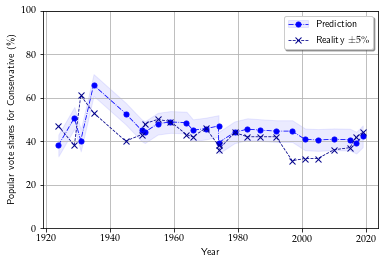

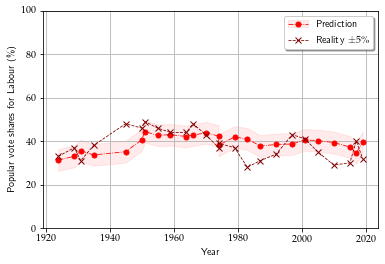

In [10]:
Mean = {p: np.array(Mean[p]) for p in parties}
Std = {p: np.array(Std[p]) for p in parties}

for p in parties:
            
    color = party_color[p]
    color2 = party_color2[p]
    
    # plot
    plt.grid()
    fill = plt.fill_between(year[2:-1],  Mean[p][:-1]-5,  Mean[p][:-1]+5, color=color, alpha=.08)
    pred, = plt.plot(year[2:-1], Mean[p][:-1], marker="o", markersize=5, ls="-.", linewidth=.8, color=color)
    real, = plt.plot(year[2:-1], X[p][2:], marker="x", ls="--", linewidth=.8, color=color2)
    #plt.fill_between(year[2:-1], Mean[p][:-1]-Std[p][:-1], Mean[p][:-1]+Std[p][:-1], color="green", alpha=.1)

    # legend and axes lim
    elements = [(fill,pred), real]
    names = ["Prediction", r"Reality $\pm 5\%$"]
    plt.legend(elements, names, loc="best", shadow=True)
    plt.ylim(0,100)
    
    # show and save
    plt.xlabel("Year")
    plt.ylabel("Popular vote shares for {} (\%)".format(party_name[p]))
    #plt.savefig("pred_vs_real_{}_{}.pdf".format(region,p))
    plt.show()
    plt.close()

Now we compute absolute errors (`gap`) and running averages of those (`gap_run`).

In [12]:
gap = {p: np.array([]) for p in parties}
gap_run = {p: np.array([]) for p in parties}
window = 5 # window size for running averages

for p in parties:
    for i in range(2,length):
        s0, s1 = estimate[p][i-2]
        datapoint = X[p][i]
        density = jump_distrib[p][i-2]
        
        # gap
        g = np.abs(datapoint-Mean[p][i-2]) # normal line
        #g = np.abs(datapoint-X[p][i-1]) # to test when we predict the last result exactly
        gap[p] = np.append(gap[p], g)
        
        # gap running average
        if i-2<window:
            gap_run[p] = np.append(gap_run[p], gap[p].mean())
        else:
            gap_run[p] = np.append(gap_run[p], gap[p][i-2-window+1:i+1].mean())

Then we plot.

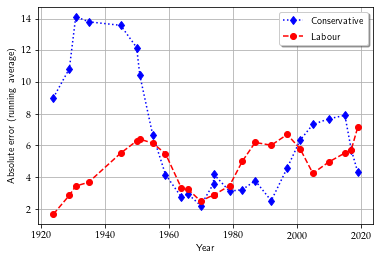

In [14]:
# plot
plt.grid()
for p in parties:
    plt.plot(year[2:-1], gap_run[p], color=party_color[p], ls=ls[p], marker=mark[p], label=party_name[p])

# legend and labels
plt.legend(loc="best", shadow=True)
plt.xlabel(r"Year")
plt.ylabel(r"Absolute error (running average)")

# save and show
#plt.savefig("{}_evolve_gap.pdf".format(region))
plt.show()
plt.close()

Basic statistics for absolute errors after model calibration. We choose the starting year.

In [15]:
if region == "uk":
    start = 9
if region =="us":
    start = 5
for p in parties:
    gap_tmp = gap[p][start:]
    print(p)
    print("min", gap_tmp.min(), year[np.argmin(gap_tmp)+start+2])
    print("max", gap_tmp.max(), year[np.argmax(gap_tmp)+start+2])
    print("mean", gap_tmp.mean())
    print()

con
min 0.055773758050911226 1979
max 13.602113993891301 1997
mean 4.632946006680303

lab
min 0.4040206901253498 2001
max 12.995641675769754 1983
mean 5.230403004506404



## Simulated elections
We simulate elections via the voter model and apply the above method. First we take the UK case: value of N1(t) for the first election, election dates and final estimates of (s0,s1). <b>Important: execute the first 5 cells of the notebook before. </b>

In [6]:
S = {"con": (19,14), "lab": (24,15)} #(s0,s1) for each party, obtained via estimation above
n_simu = 100
p = "con"
n1, s1_real, s0_real = X[p][0], S[p][1], S[p][0]

We create a specific simulation function because we want to record N1 at the real-life times of elections (ie under T)

In [7]:
def elect_simu(n, n1, s1, s0, T, length, seed=None):
        
    # init
    np.random.seed(seed)
    opinion = np.random.permutation([1]*n1 + [0]*(n-n1))
    N1 = [int(n1)]
    n1_tmp_old, n1_tmp_new = int(n1), int(n1)
    
    # stubborn
    stub0 = np.random.choice(np.where(opinion==0)[0], size=s0, replace=False)
    stub1 = np.random.choice(np.where(opinion==1)[0], size=s1, replace=False)
    
    # iter
    t, t_index = 0, 1
    while t < T[-2]:
        u = np.random.choice(range(n))
        if u not in stub0 and u not in stub1:
            n1_tmp_old = n1_tmp_new
            old_opi = opinion[u]
            opinion[u] = np.random.choice(opinion[range(n)])
            n1_tmp_new = n1_tmp_old + opinion[u] - old_opi
        waiting = np.random.exponential(1/n) # random exp of param n
        t += waiting
        if t >= T[t_index]:
            N1.append(int(n1_tmp_old))
            t_index += 1
            
    # complete if needed
    if len(N1) < length:
        N1 += [n1_tmp_new]*(length-len(N1))
    
    # end
    return np.array(N1)

Simulate `n_simu` sequences of elections via the voter model.

In [8]:
N1 = np.zeros((n_simu, length), dtype=int)
start = time()
for k in range(n_simu):
    sys.stdout.flush()
    sys.stdout.write("Party {} ...... Simu {}/{} ...... Elapsed time {}\r".format(p, k+1, n_simu, time()-start))
    N1[k,:] = elect_simu(n, n1, s1_real, s0_real, T, length-1, seed=None)
    if N1[-1].size != length:
        print("error")
        break

Save or load N1.

In [8]:
#pickle.dump(N1, open("data/elections/simu/N1.p", "wb"))
N1 = pickle.load(open("data/elections/simu/N1.p", "rb"))

Perform estimates for each simulation.

In [ ]:
### estim = {"s0": np.zeros((n_simu, length-1)), "s1": np.zeros((n_simu, length-1))}
start = time()

for k in range(n_simu): # for each simulation
        
    for j in range(2, length+1): # new estimates for each datapoint
    
        #if j < length: # we only estimate the whole data for now
            #continue
        
        xbar_tmp = N1[k,:j].mean()
        s1_max = N1[k,:j].min()
        current_max, best_estim = None, None

        for s1 in range(1, s1_max+1): # check all possible values of s1
            s0_max = n - N1[k,:j].max()
            #s0 = int(min(s0_max, round((n/xbar[p]-1)*s1)))
            for s0 in range(1, s0_max+1): # check all possible values of s0

                # print status
                sys.stdout.flush()
                sys.stdout.write("Simu {}/{} ...... datapoint {}/{} ...... elapsed time {:.3f} .....\r"
                                 .format(k+1, n_simu, j, length, time()-start))

                # compute Q
                Q = Q_matrix(n,s0,s1)

                # compute log likelihood
                log_likelihood = 0
                for i in range(1, j):
                    t = T[i] - T[i-1]
                    x, y = N1[k,i-1], N1[k,i]
                    log_likelihood += np.log(expm(t*Q)[x-s1, y-s1])

                # update max if better
                if current_max == None:
                    current_max, best_estim = log_likelihood, (s0,s1)
                elif log_likelihood > current_max:
                    current_max, best_estim = log_likelihood, (s0,s1)

        # append best estim to S0 and S1 dicts 
        estim["s0"][k,j-2], estim["s1"][k,j-2] = best_estim[0], best_estim[1]
        
        # save with pickle
        pickle.dump(estim, open("data/elections/simu/s0s1_simu{}_point{}.p".format(k+1,j-1), "wb"))

Save or load result.

In [10]:
#pickle.dump(estim, open("s0s1_new", "wb"))
estim = pickle.load(open("data/elections/simu/s0s1.p", "rb"))

Convert to integers.

In [11]:
estim = {s: estim[s].astype(int) for s in estim.keys()}

If need be, convert to integers and remove simulations that weren't finished estimating.

In [16]:
if False:
    for s in estim:
        estim[s] = estim[s].astype(int)
        for i in range(n_simu):
            arr = estim[s][i,:]
            if arr[arr==0].size > 0:
                estim[s] = estim[s][:i,].astype(int)
                break
    n_simu = estim["s0"].shape[0]
    print("nb simus valid: ", n_simu)

Load result from real data estimation.

In [12]:
estim_data = pickle.load(open("../AntoinePhD/research_project/results/uk_evolve_estimates.p", "rb"))
estim_data = {"s0": np.array([x[0] for x in estim_data[p]]), "s1": np.array([x[1] for x in estim_data[p]])}
print(estim_data)

{'s0': array([62, 20, 28,  1,  9, 11, 13, 13, 15, 16, 18, 18, 19, 19, 19, 20, 20,
       22, 22, 19, 18, 17, 18, 18, 19, 19]), 's1': array([38, 21, 20,  5, 10, 10, 12, 12, 14, 15, 16, 16, 17, 16, 16, 17, 17,
       18, 18, 15, 14, 13, 13, 13, 14, 14])}


Compute average estimates.

In [13]:
estim_avg = {s: np.mean(estim[s], axis=0) for s in estim}
print(estim_avg)

{'s0': array([51.97, 42.04, 34.38, 31.15, 28.22, 26.94, 25.46, 25.25, 23.89,
       23.43, 23.7 , 23.49, 23.21, 22.79, 22.71, 22.26, 22.04, 21.79,
       21.72, 21.5 , 21.2 , 20.77, 20.63, 20.42, 20.4 , 20.29]), 's1': array([35.26, 28.94, 25.31, 23.1 , 21.17, 20.29, 19.28, 19.09, 18.03,
       17.48, 17.67, 17.43, 17.26, 16.95, 16.84, 16.41, 16.32, 16.11,
       16.03, 15.84, 15.67, 15.42, 15.31, 15.16, 15.12, 14.99])}


Plot average estimates and data estimates over time.

s0


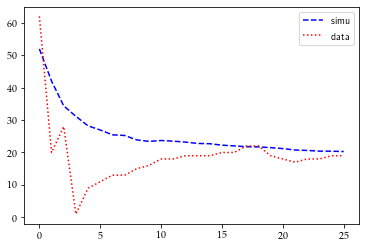

s1


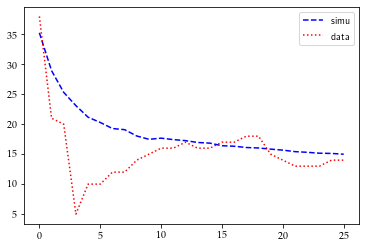

In [14]:
time_range = np.linspace(T[2], T[-1], length-1)
for s in estim:
    print(s)
    plt.plot(estim_avg[s], ls="--", color="blue", label="simu")    
    plt.plot(estim_data[s], ls=":", color="red", label="data")
    plt.legend(loc="best")
    plt.show()
    plt.close()

We compute the predicted distributions, each time based on the most recent estimate of s0,s1.

In [15]:
maximum = 0
jump_distrib = {k: list() for k in range(n_simu)}
Max = {k: list() for k in range(n_simu)}
Mean = {k: list() for k in range(n_simu)}
Std = {k: list() for k in range(n_simu)}
    
for k in range(n_simu):
    for i in range(2, length+1):

        # compute Q but only if it's the first time or s0,s1 are different than last time
        s0,s1 = estim["s0"][k][i-2], estim["s1"][k][i-2]
        Q = Q_matrix(n,s0,s1)

        # predict distribution
        t = T[i] - T[i-1]
        x = N1[k,i-1]
        density = expm(t*Q)[x-s1,:]
        jump_distrib[k].append(density)
        maximum = max(maximum, density.max())

        # mean and std and max
        mean = np.arange(s1,n-s0+1).dot(density)
        Mean[k].append(mean)
        Std[k].append(np.sqrt((np.arange(s1,n-s0+1)**2).dot(density) - mean**2))
        Max[k].append(np.argmax(density)+s1)

    # convert to array    
    jump_distrib[k] = np.array(jump_distrib[k])

Now we look at the error for each simulations. <b> to be rewritten </b>

In [16]:
gap = {k: np.array([]) for k in range(n_simu)}
gap_run = {k: np.array([]) for k in range(n_simu)}
window = 5 # window size for running averages

for k in range(n_simu):
    
    for i in range(2,length):
        
        s0, s1 = estim["s0"][k][i-2], estim["s1"][k][i-2]
        datapoint = N1[k,i]
        density = jump_distrib[k][i-2]

        # gap
        g = np.abs(datapoint-Mean[k][i-2])
        gap[k] = np.append(gap[k], g)

        # gap running average
        if i-2<window:
            gap_run[k] = np.append(gap_run[k], gap[k].mean())
        else:
            gap_run[k] = np.append(gap_run[k], gap[k][i-2-window+1:i+1].mean())

Compute means across all simulations.

In [17]:
gap_sum, gap_run_sum = gap[0], gap_run[0]
for k in range(1, n_simu):
    gap_sum += gap[k]
    gap_run_sum += gap_run[k]
gap_mean = gap_sum / n_simu
gap_run_mean = gap_run_sum / n_simu

Then we plot the mean gap_run across all simulations.

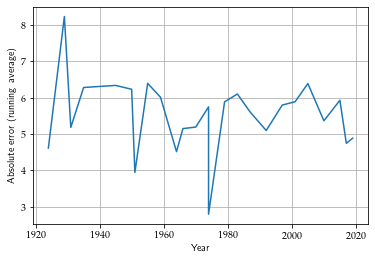

In [18]:
# plot
plt.grid()
plt.plot(year[2:-1], gap_mean)

# legend and labels
plt.xlabel(r"Year")
plt.ylabel(r"Absolute error (running average)")

# save and show
#plt.savefig("{}_evolve_gap.pdf".format(region))
plt.show()
plt.close()

Basic statistics for absolute errors after model calibration. We choose the starting year.

In [19]:
print(gap_run_mean)
print(gap_mean.mean())

[4.61461469 6.42453963 6.01088343 6.078513   6.13063976 6.45417541
 5.59605516 5.83836243 5.78469314 5.41992054 5.20354522 5.45319033
 5.32385786 4.68014146 4.95444762 5.14489066 5.22731994 5.09723952
 5.6980437  5.69832568 5.7557886  5.70787182 5.87419613 5.66356077
 5.46361374]
5.533389467721531


Now compare the expected values (from jump distrib) with simulation.

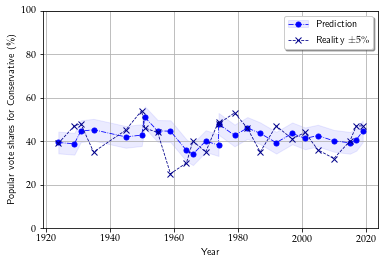

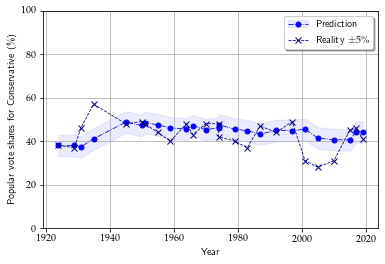

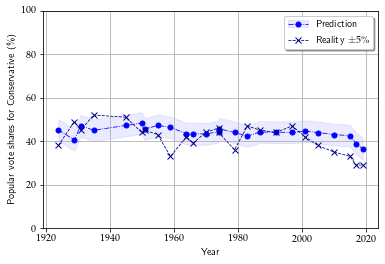

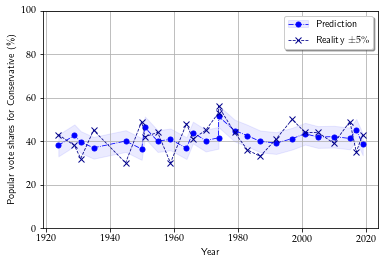

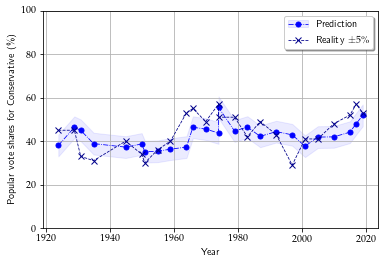

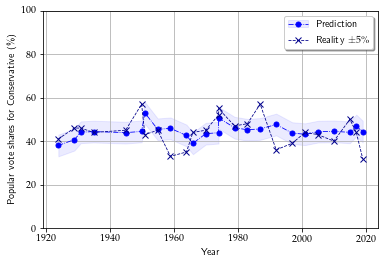

In [21]:
simus = (1,23,34,56,89,96)
Mean = {k: np.array(Mean[k]) for k in simus}
Std ={k: np.array(Std[k]) for k in simus}

for k in simus:
    
    # plot
    plt.grid()
    fill = plt.fill_between(year[2:-1],  Mean[k][:-1]-5,  Mean[k][:-1]+5, color="blue", alpha=.08)
    pred, = plt.plot(year[2:-1], Mean[k][:-1], marker="o", markersize=5, ls="-.", linewidth=.8, color="blue")
    real, = plt.plot(year[2:-1], N1[k,2:], marker="x", ls="--", linewidth=.8, color="darkblue")

    # legend and axes lim
    elements = [(fill,pred), real]
    names = ["Prediction", r"Reality $\pm 5\%$"]
    plt.legend(elements, names, loc="best", shadow=True)
    plt.ylim(0,100)
    
    # show and save
    plt.xlabel("Year")
    plt.ylabel("Popular vote shares for {} (\%)".format(party_name[p]))
    #plt.savefig("pred_vs_real_{}_{}.pdf".format(region,p))
    plt.show()
    plt.close()